#  Quantum Fourier Transform

We implement the Quantum Fourier Transform (QFT) following [1,2], by separately defining the two main routines in the algorithm, namely rotating and swapping. We include a definition of the inverse QFT. We test it using the IBM state vector simulator and check it using the counting rules defined in [1].

Refs.:

[1] Qiskit tutorial notes: https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html

[2] Nielsen and Chuang - *Quantum computation and quantum information*

In [102]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector
from qiskit.tools.monitor import job_monitor

import numpy as np
pi=np.pi
%matplotlib inline 

### Definition of QFT and subroutines

In [115]:
def qft_rot(circuit,nq):
    ''' First part of the Quantum Fourier Transform. This function performs rotations 
    on a specific target qubit, which are controlled by remaining qubits that have not 
    been rotated yet. This is therefore performed recursively in order to progressively 
    reduce the number of qubits affected by the operation. The particular order of operation 
    has been set such that it follows the notation order in Qiskit. The target qubit is 
    thus the last one in the circuit and the function recursively moves upwards.'''

    # If all qubits have been acted on return the circuit
    if nq == 0:        
        return circuit
    
    # Reduce by one the number of qubits in order to recursevely move through the circuit
    nq-=1
    
    # Act with a Hadamard gate on the target qubit
    circuit.h(nq)
    
    # Controlled rotations on the target qubit, with each one of the remaining qubits as controls
    for q in range(nq):
    
        circuit.cu1(2*pi/2**(nq+1-q),q,nq)
    
    # Recursively call the function to cover the entire circuit
    return qft_rot(circuit,nq)




def qft_swaps(circuit,nq):
    '''Second part of the Quantum Fourier transform. This function swaps qubits 
    paired from top and bottom towards the middle.'''
       
    # Swapping of each pair
    for q in range(nq//2):       
        circuit.swap(q,nq-1-q)
        
    return circuit



def qft(circuit,nq):
    '''Quantum Fourier Transform. The function is split into a series of controlled 
    rotations and swap operations. See Qiskit textbook section about QFT for details.'''
    
    # Rotations on the qubits
    circuit = qft_rot(circuit,nq)
    circuit.barrier()
    
    # Qubit swaps
    circuit = qft_swaps(circuit,nq)
    
    return circuit

### Definition of inverse QFT 

In [135]:
def inv_qft(circuit,nq):
    ''' Inverse Quantum Fourier Transform. The function first generates a Fourier transformed
    circuit. Next, exploiting the unitarity of the QFT, inverts the circuit using the .inverse()
    method. This inverted circuit is then appended to the original one.'''
    
    # Generate a circuit of size nq and apply a QFT to it
    circuit_qft = qft(QuantumCircuit(nq),nq)
    
    # Invert the transformed circuit and append it to the original one
    circuit += circuit_qft.inverse()
    
    return circuit

### Initial State Encoder

In [127]:
def init_bin(circuit,n,num_bin):
    '''This function encodes the initial state defined by an input binary number.'''
    
    # We reverse the order of the state to match the readout convention in Qiskit
    num_bin = num_bin[::-1]
    
    # Flip the corresponding qubits to encode the binary number
    for q in range(n):
        if num_bin[q] == '1':
            circuit.x(q)
    
    return circuit

### QFT implementation

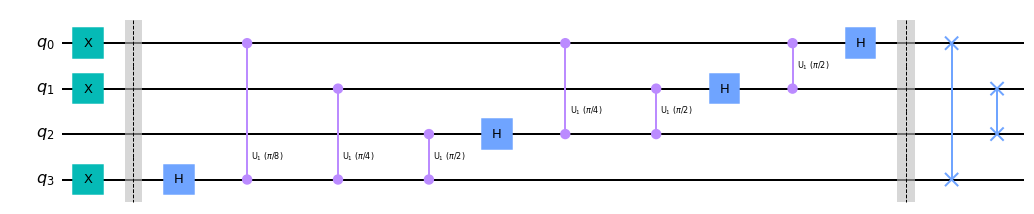

In [142]:
num = 11 # Choose state number to Fourier transform
num_bin = format(num,'b') # Convert to binary


# Number of qubits corresponds to the length of the binary number
nqubits = len(num_bin) 


circ = QuantumCircuit(nqubits)


# Initialize the circuit to the state we will transform
circ = init_bin(circ,nqubits,num_bin)
circ.barrier()

# Apply Quantum Fourier transform
circ = qft(circ,nqubits)


circ.draw(output='mpl')

#### Classical simulation

In [137]:
sim = Aer.get_backend('statevector_simulator')
qft_result = execute(circ, backend = sim, shots = 1024).result()

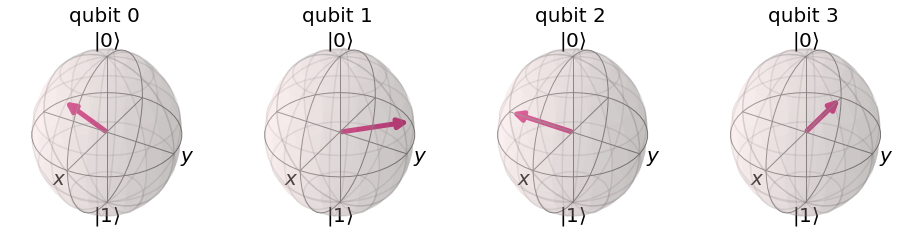

In [138]:
qft_sv = qft_result.get_statevector()
plot_bloch_multivector(qft_sv)

Using the counting rules defined in [1], we can check this is indeed the fourier transform of 11 as $q_0$ as been rotated in the XY plane by $2\pi\frac{11}{2^4}$, $q_1$ by $2\pi\frac{11}{2^3}$, $q_2$ by $2\pi\frac{11}{2^2}$ and $q_3$ by $2\pi\frac{11}{2}$. For a final check, we append the inverse Fourier transform and check that we retrieve the original state.

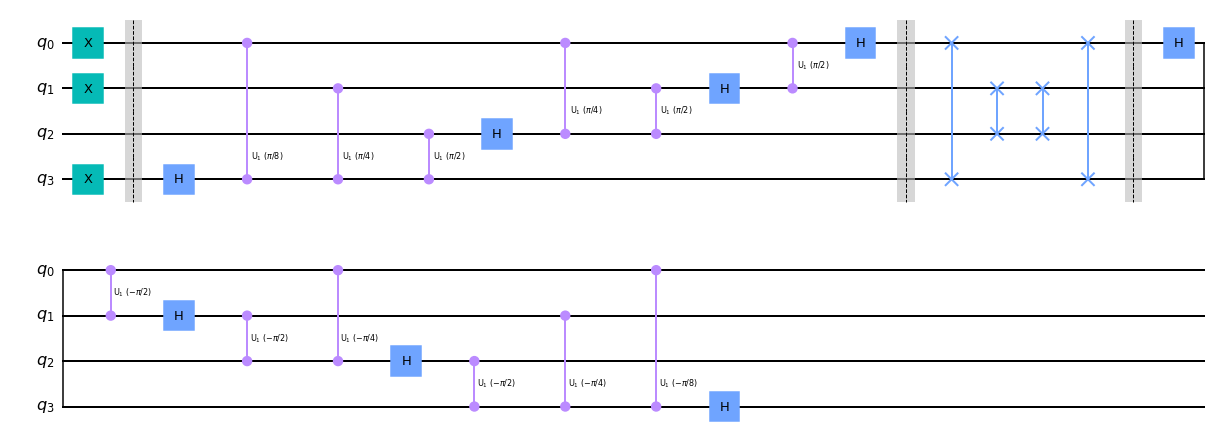

In [143]:
circ = inv_qft(circ,nqubits)

circ.draw(output='mpl')

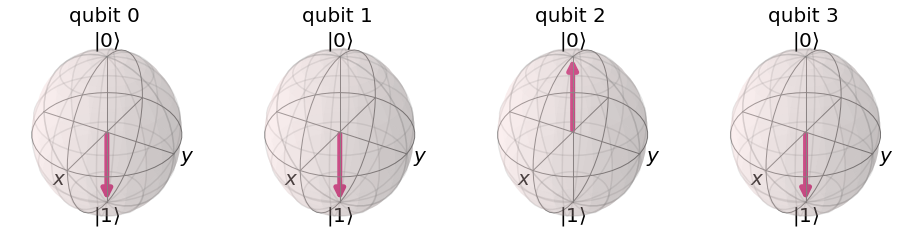

In [144]:
qft_result = execute(circ, backend = sim, shots = 1024).result()
qft_sv = qft_result.get_statevector()
plot_bloch_multivector(qft_sv)

Reading it in Qiskit convention (from right to left) we obtain 1011, which is nothing but 11 in binary. This means both of our functions are working correctly!